# Phase 2 — Advanced Preprocessing & Feature Engineering

Split before scaling, create Standard and MinMax scaled datasets, correlation analysis, feature importance, and save processed data for reproducibility.

**Works with:** CIC-IoT-2023 or CICIDS2017 (auto-detects from Phase 1)

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import psutil
import gc
from sklearn.ensemble import RandomForestClassifier



print("Libraries imported successfully")

Libraries imported successfully


In [2]:
# ===================================================================
# Memory Optimization Utilities
# ===================================================================

def get_memory_usage():
    """Get current memory usage in GB"""
    process = psutil.Process()
    return process.memory_info().rss / 1024**3

def optimize_dtypes(df):
    """Reduce memory usage by optimizing data types"""
    print("\nOptimizing data types...")
    start_mem = df.memory_usage(deep=True).sum() / 1024**3
    print(f"  Initial memory: {start_mem:.2f} GB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage(deep=True).sum() / 1024**3
    saved = start_mem - end_mem
    print(f"  Final memory: {end_mem:.2f} GB")
    print(f"  Saved: {saved:.2f} GB ({100 * saved / start_mem:.1f}%)")
    
    return df

print(f"System RAM: {psutil.virtual_memory().total / 1024**3:.1f} GB")
print(f"Available RAM: {psutil.virtual_memory().available / 1024**3:.1f} GB")
print(f"Current process memory: {get_memory_usage():.2f} GB")

System RAM: 15.7 GB
Available RAM: 4.4 GB
Current process memory: 0.21 GB


In [3]:
# ===================================================================
# Auto-detect dataset from Phase 1
# ===================================================================
# Check which dataset was processed in Phase 1
if Path("../data/processed/CICIoT2023/combined.csv").exists():
    DATASET = "CICIoT2023"
    DATA_DIR = Path("../data/processed/CICIoT2023")
elif Path("../data/processed/CICIDS2017/combined.csv").exists():
    DATASET = "CICIDS2017"
    DATA_DIR = Path("../data/processed/CICIDS2017")
else:
    raise FileNotFoundError("No processed dataset found. Please run Notebook 01 first!")

OUT_DIR = Path("../data/processed/ml_ready")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Detected Dataset: {DATASET}")
print(f"Data Directory: {DATA_DIR}")

Detected Dataset: CICIoT2023
Data Directory: ..\data\processed\CICIoT2023


In [4]:
# ===================================================================
# Load consolidated data created in Phase 1 (MEMORY-OPTIMIZED)
# ===================================================================
print(f"\nLoading consolidated data from Phase 1...")
print(f"Memory before loading: {get_memory_usage():.2f} GB")

# First, read header to identify columns
sample = pd.read_csv(DATA_DIR / "combined.csv", nrows=1)
sample.columns = sample.columns.str.strip()

# Identify label columns (string/object type)
label_cols = [col for col in sample.columns
             if col.lower() in ["label", "attack", "class", "label_id"]]

# Create dtype specification: float32 for all except label columns
dtypes = {col: np.float32 for col in sample.columns if col not in label_cols}

# Load with optimized dtypes and progress bar
print("Loading with optimized data types...")

from tqdm import tqdm

# Get file size for progress tracking
file_path = DATA_DIR / "combined.csv"
file_size = file_path.stat().st_size

# Read in chunks with progress bar
chunks = []
chunk_size = 1_000_000  # 1 million rows per chunk

with tqdm(total=file_size, unit='B', unit_scale=True, desc="Loading dataset") as pbar:
    for chunk in pd.read_csv(file_path, dtype=dtypes, chunksize=chunk_size, low_memory=False):
        chunks.append(chunk)
        # Update progress based on memory usage (approximate)
        pbar.update(len(chunk) * len(chunk.columns) * 4)  # Approximate bytes

print("Combining chunks...")
df = pd.concat(chunks, ignore_index=True)
del chunks
gc.collect()

# Optimize Label_ID to int16 if present
if "Label_ID" in df.columns:
    df["Label_ID"] = df["Label_ID"].astype(np.int16)

print(f"\nDataset shape: {df.shape}")
print(f"Memory after loading: {get_memory_usage():.2f} GB")

X = df.drop(columns=["label" if "label" in df.columns else "Label", "Label_ID"])
y = df["Label_ID"]

# Free memory
del df
gc.collect()

print(f"\nFeatures: {X.shape[1]}")
print(f"Samples: {X.shape[0]:,}")
print(f"Classes: {y.nunique()}")
print(f"Memory after cleanup: {get_memory_usage():.2f} GB")


Loading consolidated data from Phase 1...
Memory before loading: 0.21 GB
Loading with optimized data types...


Loading dataset:  75%|███████▌  | 8.96G/11.9G [07:12<02:21, 20.7MB/s]


Combining chunks...

Dataset shape: (46686579, 48)
Memory after loading: 5.36 GB

Features: 46
Samples: 46,686,579
Classes: 34
Memory after cleanup: 2.31 GB


In [5]:
# ===================================================================
# Train-test split BEFORE scaling
# ===================================================================
print("\n" + "=" * 60)
print("Train-Test Split")
print("=" * 60)

print(f"Memory before split: {get_memory_usage():.2f} GB")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Free memory from original X, y
del X, y
gc.collect()

print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")
print(f"Memory after split: {get_memory_usage():.2f} GB")



Train-Test Split
Memory before split: 2.31 GB
Train shape: (37349263, 46)
Test shape:  (9337316, 46)
Memory after split: 1.88 GB



Correlation Analysis
Memory before correlation: 1.88 GB
Dataset has 37,349,263 samples - using stratified sample of 100,000 for faster correlation
Computing correlation matrix on 100,000 samples...
Calculating correlations...
Correlation matrix computed: (46, 46)
Memory after correlation: 8.09 GB
Saving correlation plot...
  Saved: feature_correlation.png (high res)
  Saved: feature_correlation_low.png (low res for quick view)


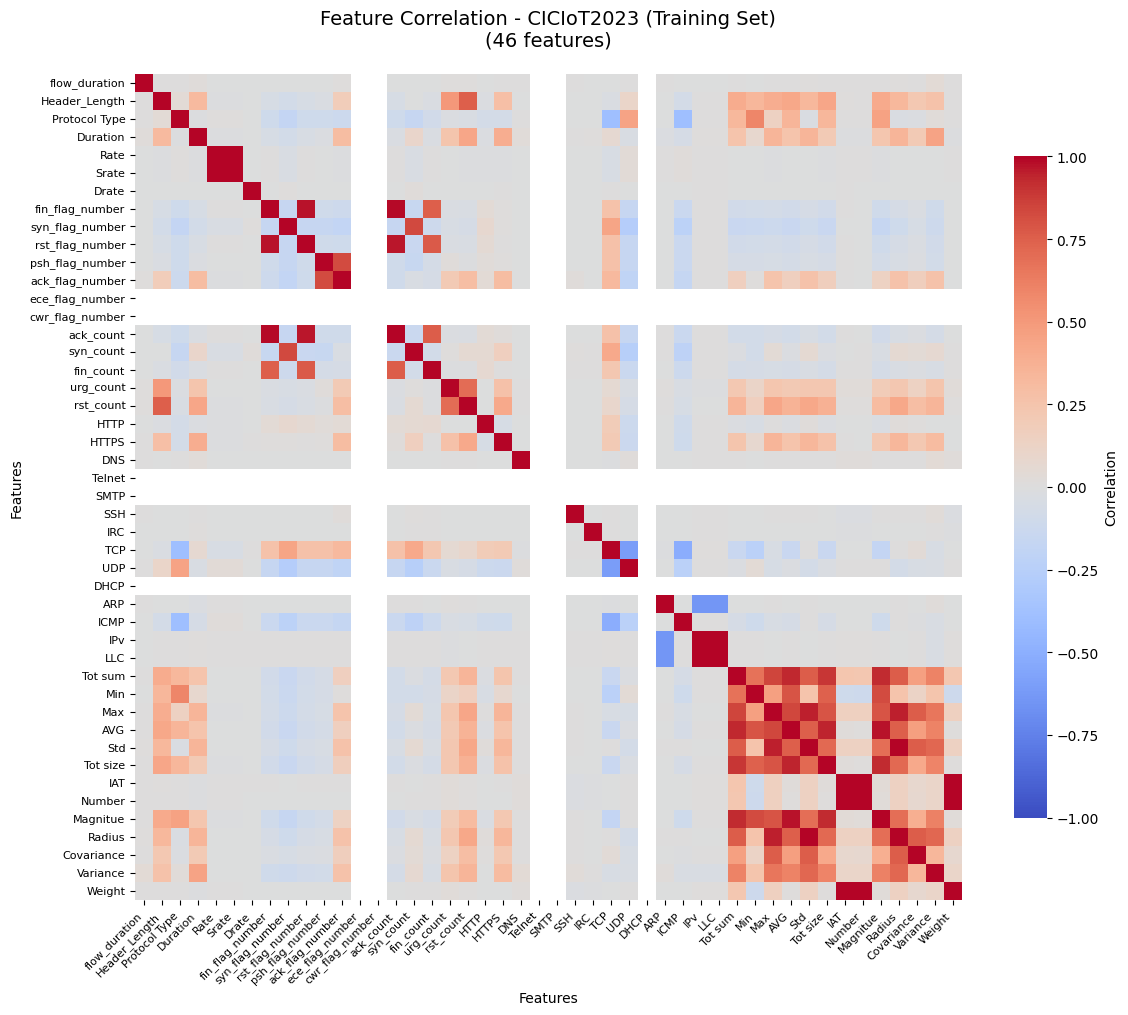

  Saved: correlation_matrix.csv (46x46)


In [6]:
# ===================================================================
# Correlation analysis on training set (original features) - OPTIMIZED
# ===================================================================
print("\n" + "=" * 60)
print("Correlation Analysis")
print("=" * 60)

print(f"Memory before correlation: {get_memory_usage():.2f} GB")

# Optimize: Use sample if dataset is too large for correlation
n_samples = X_train.shape[0]
max_samples_for_corr = 100_000  # Correlation is stable with large samples

if n_samples > max_samples_for_corr:
    print(f"Dataset has {n_samples:,} samples - using stratified sample of {max_samples_for_corr:,} for faster correlation")
    from sklearn.utils import resample
    X_corr = resample(X_train, n_samples=max_samples_for_corr, random_state=42, stratify=None)
else:
    X_corr = X_train

print(f"Computing correlation matrix on {X_corr.shape[0]:,} samples...")

# Use numpy for faster computation if possible
if isinstance(X_corr, pd.DataFrame):
    # Optimize: Compute correlation with method='pearson' (default, but explicit)
    from tqdm import tqdm
    print("Calculating correlations...")
    corr = X_corr.corr(method='pearson')
else:
    corr = pd.DataFrame(X_corr).corr(method='pearson')

# Clean up sample data
if n_samples > max_samples_for_corr:
    del X_corr
    gc.collect()

print(f"Correlation matrix computed: {corr.shape}")
print(f"Memory after correlation: {get_memory_usage():.2f} GB")

# Optimize: Create heatmap with downsampling for large matrices
n_features = corr.shape[0]

if n_features > 50:
    print(f"\nNote: {n_features} features - heatmap may be crowded")
    print("Saving full correlation matrix, displaying top 50 features")
    
    # Get top 50 features by variance in correlation
    corr_var = corr.var()
    top_features = corr_var.nlargest(50).index
    corr_display = corr.loc[top_features, top_features]
else:
    corr_display = corr

# Create optimized heatmap
plt.figure(figsize=(12, 10))

# Optimize: Use square=True for better visualization, annot=False for speed
sns.heatmap(
    corr_display, 
    cmap="coolwarm", 
    center=0, 
    square=True,
    linewidths=0,  # Remove grid lines for faster rendering
    cbar_kws={"label": "Correlation", "shrink": 0.8},
    vmin=-1, 
    vmax=1
)

plt.title(f"Feature Correlation - {DATASET} (Training Set)\n({corr_display.shape[0]} features)", fontsize=14, pad=20)
plt.xlabel("Features", fontsize=10)
plt.ylabel("Features", fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()

# Save with optimization
print("Saving correlation plot...")
plt.savefig(OUT_DIR / "feature_correlation.png", dpi=300, bbox_inches="tight", facecolor='white')
plt.savefig(OUT_DIR / "feature_correlation_low.png", dpi=150, bbox_inches="tight", facecolor='white')  # Lower res for quick view
print(f"  Saved: feature_correlation.png (high res)")
print(f"  Saved: feature_correlation_low.png (low res for quick view)")
plt.show()

# Save correlation matrix to CSV for later analysis
corr.to_csv(OUT_DIR / "correlation_matrix.csv")
print(f"  Saved: correlation_matrix.csv ({corr.shape[0]}x{corr.shape[1]})")

In [ ]:
# Compute and remove highly correlated features
print("\nIdentifying highly correlated features...")
threshold = 0.95
high_corr = []
cols = corr.columns
to_drop = set()

for i in range(len(cols)):
    for j in range(i):
        if abs(corr.iloc[i,j]) > threshold:
            high_corr.append((cols[i], cols[j], corr.iloc[i,j]))
            # Drop the second feature in the pair
            to_drop.add(cols[j])

print(f"High correlation pairs (>|0.95|): {len(high_corr)} pairs found")

if to_drop:
    print(f"Dropping {len(to_drop)} highly correlated features:")
    for col in sorted(to_drop):
        print(f"  - {col}")
    
    # Remove from both train and test
    X_train = X_train.drop(columns=list(to_drop))
    X_test = X_test.drop(columns=list(to_drop))
    print(f"\nNew feature count: {X_train.shape[1]}")
else:
    print("No highly correlated features to remove")

# Free correlation matrix memory
del corr
gc.collect()
print(f"Memory after cleanup: {get_memory_usage():.2f} GB")



Identifying highly correlated features...
High correlation pairs (>|0.95|): 12 pairs found
Dropping 9 highly correlated features:
  - AVG
  - IAT
  - IPv
  - Max
  - Number
  - Rate
  - Std
  - fin_flag_number
  - rst_flag_number

New feature count: 37
Memory after cleanup: 3.50 GB


In [ ]:

# Fit scalers on training data only (after feature removal)

print("Scaling Features")

print(f"Memory before scaling: {get_memory_usage():.2f} GB")

std_scaler = StandardScaler().fit(X_train)
mm_scaler = MinMaxScaler().fit(X_train)

X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

X_train_mm = mm_scaler.transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

print("StandardScaler fitted and applied")
print("MinMaxScaler fitted and applied")
print(f"Memory after scaling: {get_memory_usage():.2f} GB")



Scaling Features
Memory before scaling: 2.69 GB
StandardScaler fitted and applied
MinMaxScaler fitted and applied
Memory after scaling: 10.45 GB


In [9]:
# ===================================================================
# Save scalers and processed arrays
# ===================================================================
print("\n" + "=" * 60)
print("Saving Processed Data")
print("=" * 60)

joblib.dump(std_scaler, Path("../trained_models/scaler_standard.pkl"))
joblib.dump(mm_scaler, Path("../trained_models/scaler_minmax.pkl"))
print(" Saved scalers")

pd.DataFrame(X_train_std, columns=X_train.columns).to_csv(OUT_DIR / "X_train_standard.csv", index=False)
pd.DataFrame(X_test_std, columns=X_test.columns).to_csv(OUT_DIR / "X_test_standard.csv", index=False)
pd.DataFrame(X_train_mm, columns=X_train.columns).to_csv(OUT_DIR / "X_train_minmax.csv", index=False)
pd.DataFrame(X_test_mm, columns=X_test.columns).to_csv(OUT_DIR / "X_test_minmax.csv", index=False)

y_train.to_csv(OUT_DIR / "y_train.csv", index=False)
y_test.to_csv(OUT_DIR / "y_test.csv", index=False)

print(f"Saved processed data to {OUT_DIR}")



Saving Processed Data
✓ Saved scalers
✓ Saved processed data to ..\data\processed\ml_ready


In [10]:
# Print file sizes
for file in OUT_DIR.glob("*.csv"):
    size_mb = file.stat().st_size / (1024**2)
    print(f"  {file.name}: {size_mb:.2f} MB")

print(f"\nPhase 2 complete!")
print(f"Final feature count: {X_train.shape[1]}")
print(f"Training samples: {X_train.shape[0]:,}")
print(f"Test samples: {X_test.shape[0]:,}")

  correlation_matrix.csv: 0.03 MB
  X_test_minmax.csv: 2100.20 MB
  X_test_standard.csv: 3995.26 MB
  X_train_minmax.csv: 8400.74 MB
  X_train_standard.csv: 15981.02 MB
  y_test.csv: 32.33 MB
  y_train.csv: 129.34 MB

Phase 2 complete!
Final feature count: 37
Training samples: 37,349,263
Test samples: 9,337,316



=== Feature Importance Analysis ===

Top 20 Most Important Features:
            feature  importance
32         Magnitue    0.105795
31         Tot size    0.096148
30              Min    0.073051
11        ack_count    0.068053
12        syn_count    0.066542
1     Header_Length    0.065199
13        fin_count    0.056112
29          Tot sum    0.053293
6   syn_flag_number    0.051534
2     Protocol Type    0.048527
7   psh_flag_number    0.046392
0     flow_duration    0.045167
14        urg_count    0.037727
4             Srate    0.029198
27             ICMP    0.029145
15        rst_count    0.026927
24              UDP    0.024548
8   ack_flag_number    0.021958
23              TCP    0.019113
33           Radius    0.010343

Saved feature importance to ..\data\processed\ml_ready\feature_importance.csv


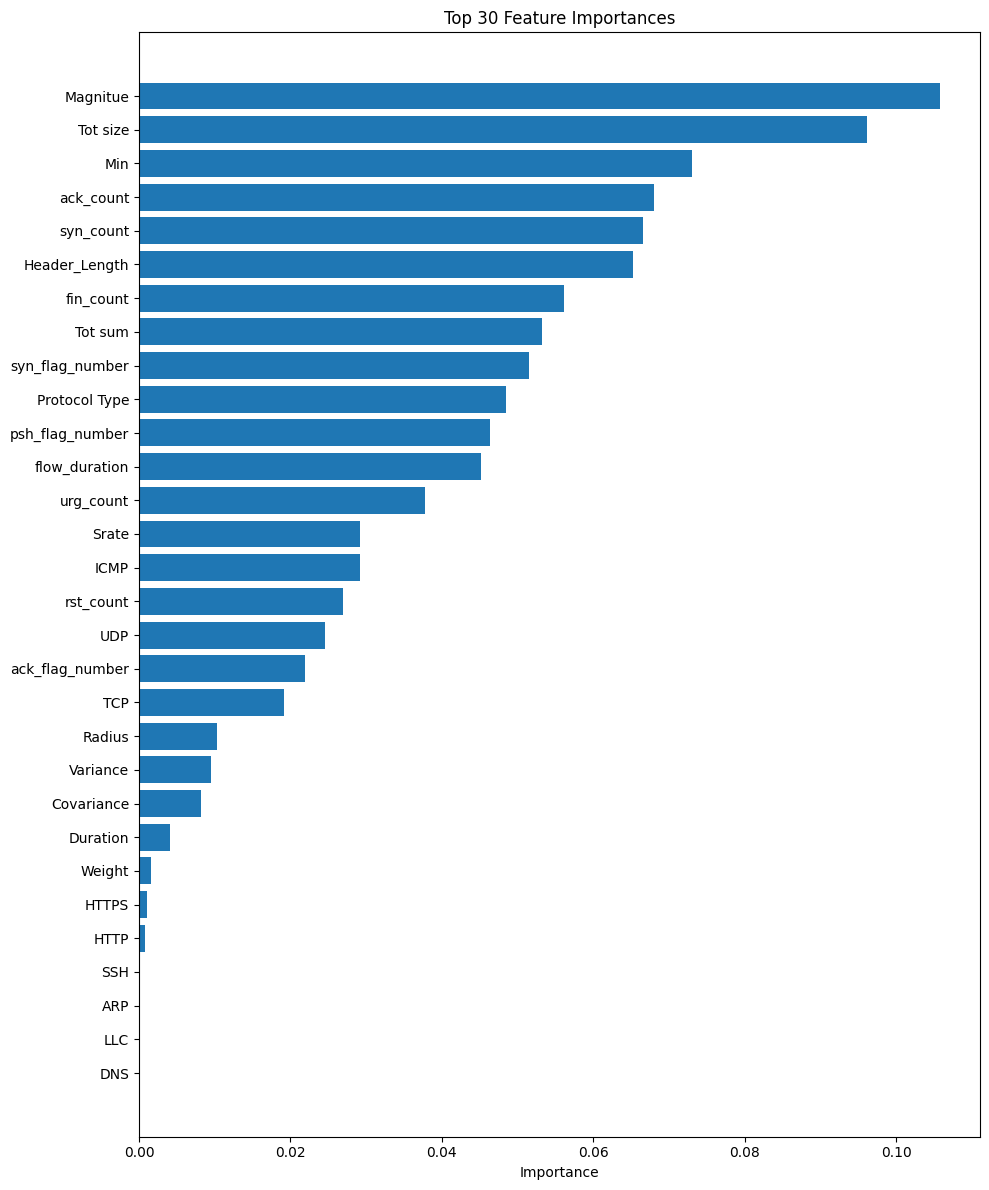

In [11]:
# Feature importance-based selection using Random Forest
print("\n=== Feature Importance Analysis ===")
# Train a quick RF to get feature importances
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf_selector.fit(X_train_std, y_train)

# Get feature importances
importances = rf_selector.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(importance_df.head(20))

# Optional: Select top N features or features above threshold
# Uncomment to apply feature selection
# top_n_features = 50
# selected_features = importance_df.head(top_n_features)['feature'].tolist()
# X_train = X_train[selected_features]
# X_test = X_test[selected_features]
# print(f"\nReduced to top {top_n_features} features")

# Save feature importance for reference
importance_df.to_csv(OUT_DIR / "feature_importance.csv", index=False)
print("\nSaved feature importance to", OUT_DIR / "feature_importance.csv")

# Plot top 30 features
plt.figure(figsize=(10, 12))
top_30 = importance_df.head(30)
plt.barh(range(len(top_30)), top_30['importance'])
plt.yticks(range(len(top_30)), top_30['feature'])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()